# CODE SNIPPET TO RUN PYCIGAR WITHOUT RL-AGENT

In [1]:
import pycigar
import pandas as pd
from pycigar.utils.input_parser import input_parser

In the code block below, we use `input_parser` to get the basic configuration of the experiment.
- `benchmark=True`: set the std of inverter filters to 0, disable the randomness in the environment.
- `vectorized_mode=True`: solve the PQ injection of all inverters in vectorized mode, we expect to cut down 50% of execution time vs `vectorized_mode=False`. To be able to run, we need `scipy==1.5.2`. I updated it in the requirements but you may need to reinstall it if you use the old pycigar conda env.
- The adversarial inverters always use `adaptive_fixed_controller`.

## Register new controller to PyCIGAR
To add a custom controller, we need to register it with PyCIGAR.
Assume that we now have the new controller as in here: `pycigar/controllers/custom_adaptive_inverter_controller.py`, now we want to register it with PyCIGAR.

In [2]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.custom_adaptive_inverter_controller import CustomAdaptiveInverterController
from pycigar.controllers.adaptive_inverter_controller import AdaptiveInverterController
from pycigar.controllers.custom_hack_controller import CustomHackController
from pycigar.controllers.fixed_controller import FixedController

In [3]:
register_devcon('Attacker', CustomHackController)
register_devcon('Defender', CustomAdaptiveInverterController)

'Defender'

In [6]:
pycigar.DATA_DIR

'/home/ciaran/Dropbox/AdaptiveControlPaper/smart-inverter-adaptive-control/pycigar/data'

In [5]:
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None,  names=['Parameter', 'Value'])


IndexError: list index out of range

This is where we change experiment parameters

In [92]:
misc_inputs = pd.read_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', index_col=0, header=None,  names=['Parameter', 'Value'])
misc_inputs.Value['hack start']=250
misc_inputs.Value['hack end']=2000
misc_inputs.Value['hack update']=200
misc_inputs.Value['measurement filter time constant mean']=1
misc_inputs.Value['measurement filter time constant avg v']=20
misc_inputs.Value['gamma']=0#0.001
misc_inputs.Value['k']=0
#misc_inputs.Value['solar scaling factor']=1.5
misc_inputs.to_csv(pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv', header=None)

hack=0.20

IndexError: list index out of range

In [84]:
misc_inputs = pycigar.DATA_DIR + '/ieee37busdata/misc_inputs.csv'
dss = pycigar.DATA_DIR + '/ieee37busdata/ieee37.dss'
load_solar = pycigar.DATA_DIR + '/ieee37busdata/load_solar_data.csv'
breakpoints = pycigar.DATA_DIR + '/ieee37busdata/breakpoints.csv'

sim_params = input_parser(misc_inputs, dss, load_solar, breakpoints, benchmark=True, percentage_hack=hack, vectorized_mode=False)
start = 100
sim_params['scenario_config']['start_end_time'] = [start, start + 1500]  # fix the exp start and end time
sim_params['env_config']['sims_per_step'] = 1 # on 1 step call, it is equal to 1 simulation step.
del sim_params['attack_randomization'] # turn off the attack randomization

from pycigar.envs.norl_env import NoRLEnv
env = NoRLEnv(sim_params=sim_params) # init env with the sim_params above

env.reset()
done = False
while not done:
    done = env.step() # every step call will return done, the status whether the exp is finished or not

All the information of the experiment has been logged in the `logger` of PyCIGAR.
The `logger` has 2 dictionaries:
- `logger().log_dict`: a dictionary has all informations of inverters/nodes.
- `logger().custom_metric`: a dictionary has custom metric (substation power,...) 

In [85]:
from pycigar.utils.logging import logger
Logger = logger()

print(Logger.log_dict.keys())

dict_keys(['inverter_s701a', 'adversary_inverter_s701a', 'inverter_s701b', 'adversary_inverter_s701b', 'inverter_s701c', 'adversary_inverter_s701c', 'inverter_s712c', 'adversary_inverter_s712c', 'inverter_s713c', 'adversary_inverter_s713c', 'inverter_s714a', 'adversary_inverter_s714a', 'inverter_s714b', 'adversary_inverter_s714b', 'inverter_s718a', 'adversary_inverter_s718a', 'inverter_s720c', 'adversary_inverter_s720c', 'inverter_s722b', 'adversary_inverter_s722b', 'inverter_s722c', 'adversary_inverter_s722c', 'inverter_s724b', 'adversary_inverter_s724b', 'inverter_s725b', 'adversary_inverter_s725b', 'inverter_s727c', 'adversary_inverter_s727c', 'inverter_s728', 'adversary_inverter_s728', 'inverter_s729a', 'adversary_inverter_s729a', 'inverter_s730c', 'adversary_inverter_s730c', 'inverter_s731b', 'adversary_inverter_s731b', 'inverter_s732c', 'adversary_inverter_s732c', 'inverter_s733a', 'adversary_inverter_s733a', 'inverter_s734c', 'adversary_inverter_s734c', 'inverter_s735c', 'advers

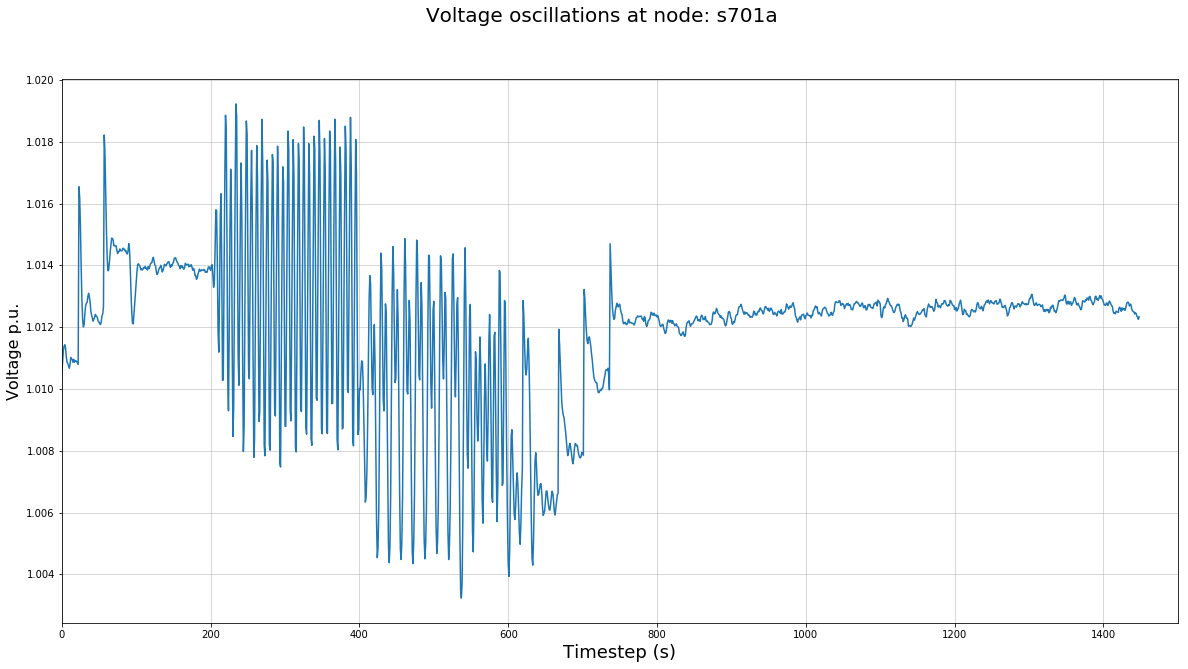

In [86]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.show()

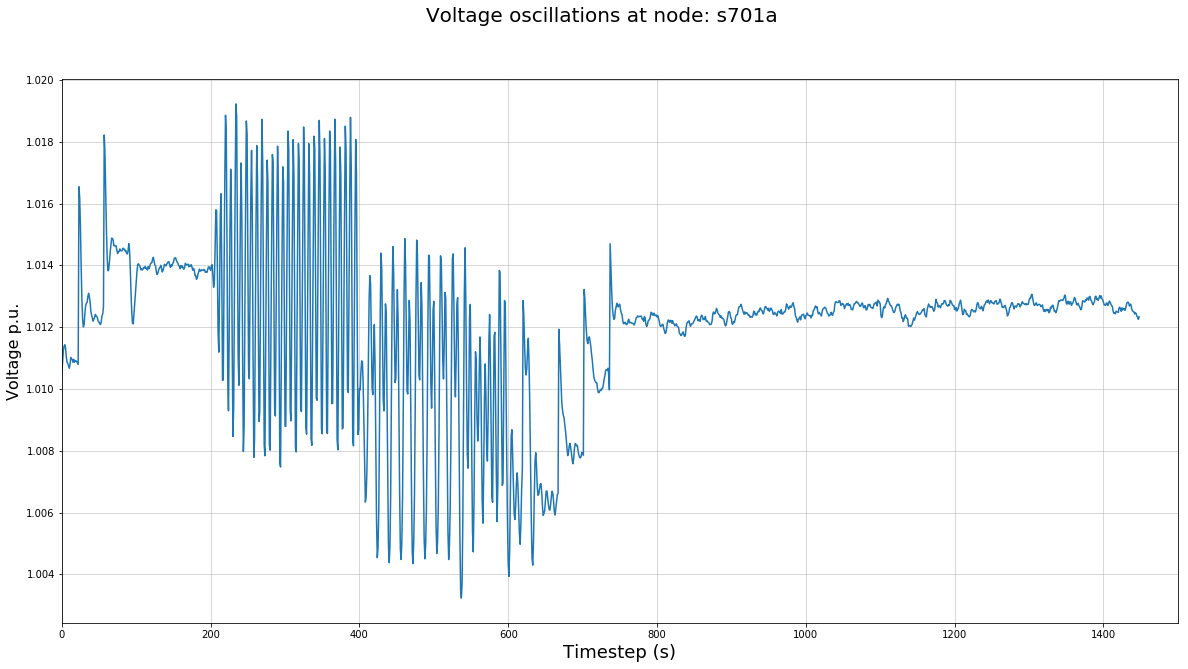

In [78]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
node_id = 's701a'
f.suptitle('Voltage oscillations at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
ax.plot(Logger.log_dict[node_id]['voltage'])
plt.show()

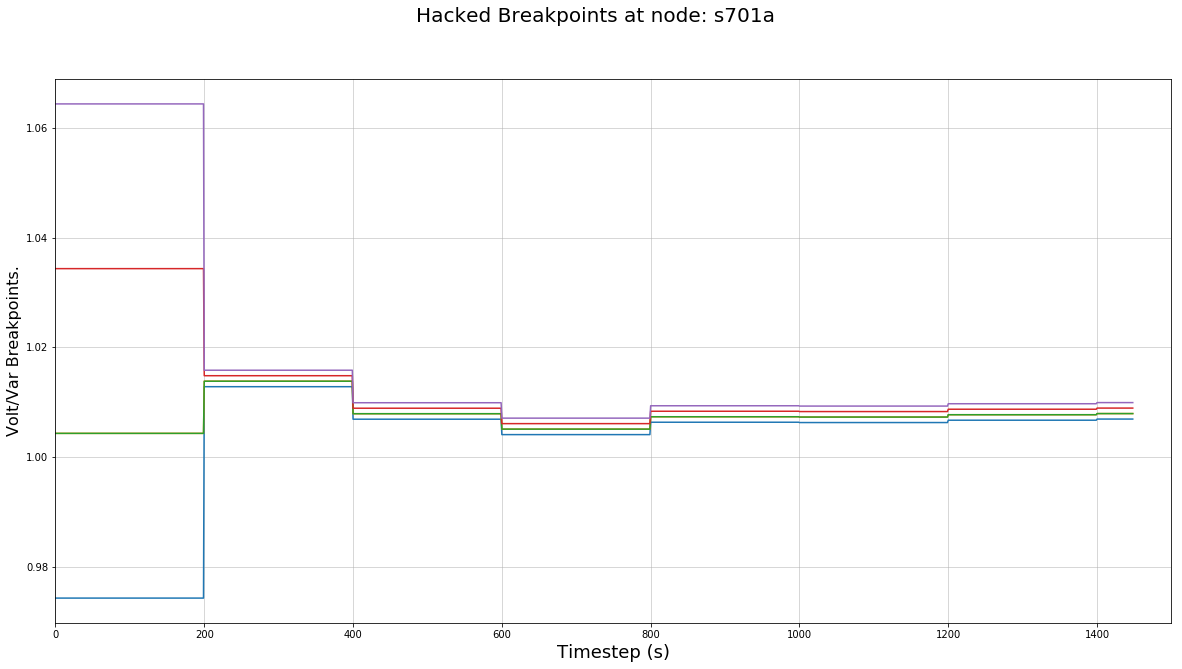

In [79]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'adversary_inverter_s701a'
f.suptitle('Hacked Breakpoints at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Volt/Var Breakpoints.', fontsize=16)
ax.plot(Logger.log_dict[key]['control_setting'])
plt.show()

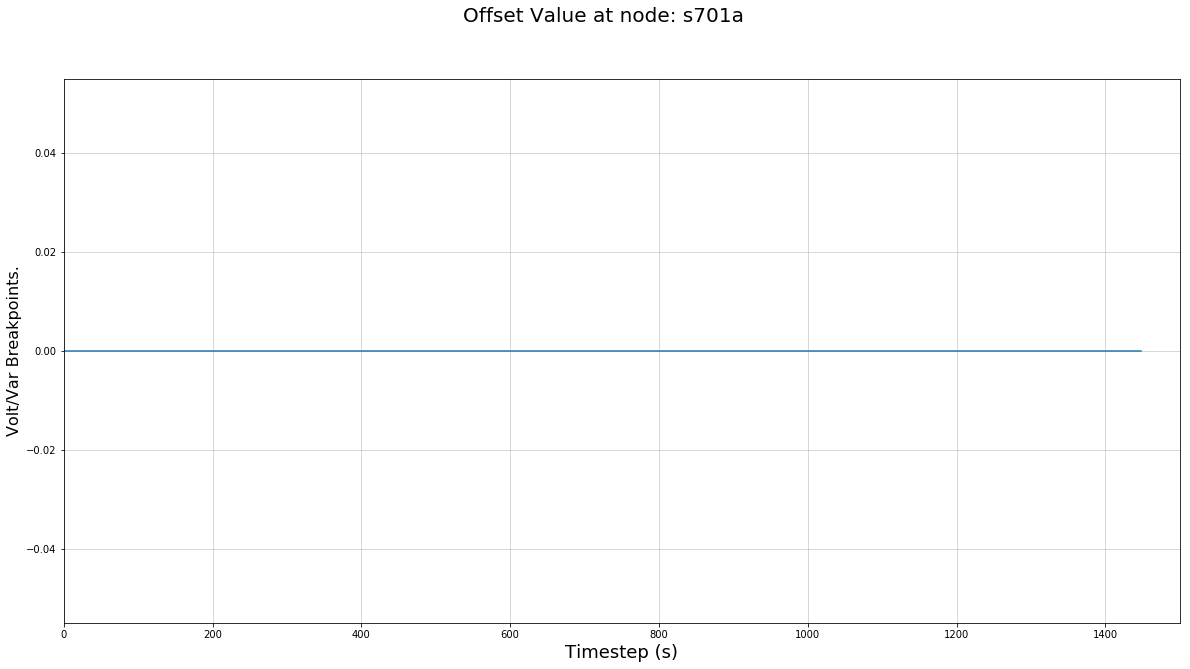

In [80]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
key = 'inverter_s701a'
f.suptitle('Offset Value at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Volt/Var Breakpoints.', fontsize=16)
ax.plot(Logger.log_dict[key]['y'])
plt.show()

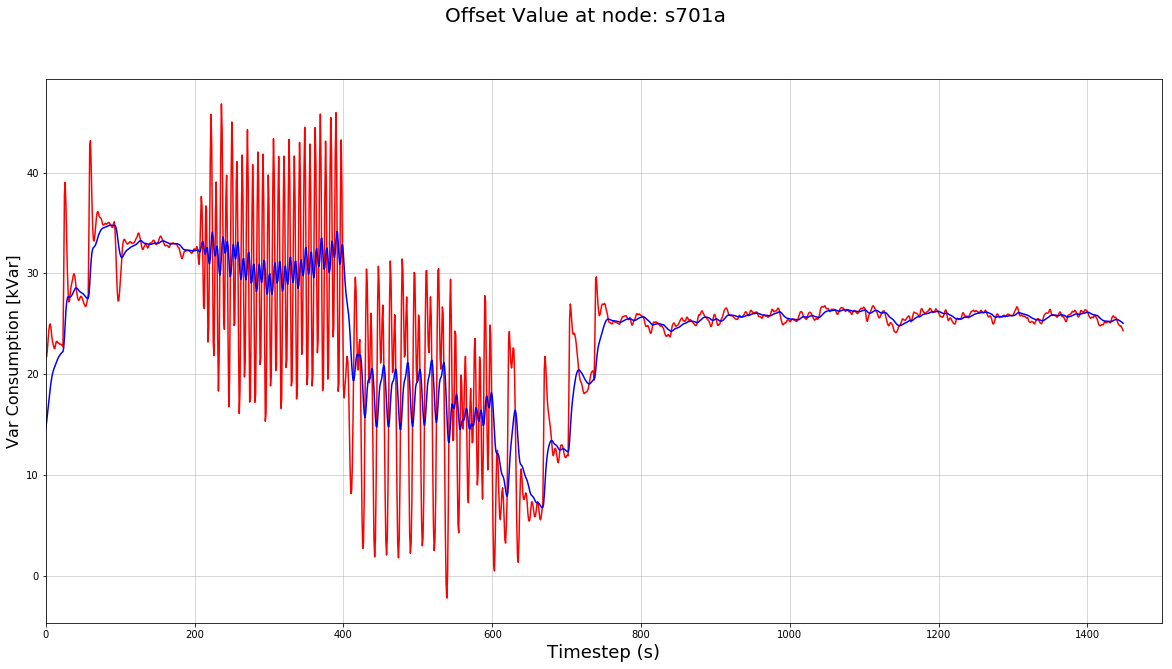

In [81]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 1500])
f.suptitle('Offset Value at node: {}'.format(node_id), fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Var Consumption [kVar]', fontsize=16)
key = 'inverter_s701a'
ax.plot(Logger.log_dict[key]['q_set'], 'r')
ax.plot(Logger.log_dict[key]['q_out'], 'b')
plt.show()

In [50]:
list(Logger.log_dict['inverter_s701a'])

['y',
 'u',
 'p_set',
 'q_set',
 'p_out',
 'q_out',
 'control_setting',
 'sbar_solarirr',
 'sbar_pset',
 'solar_irr',
 'node']

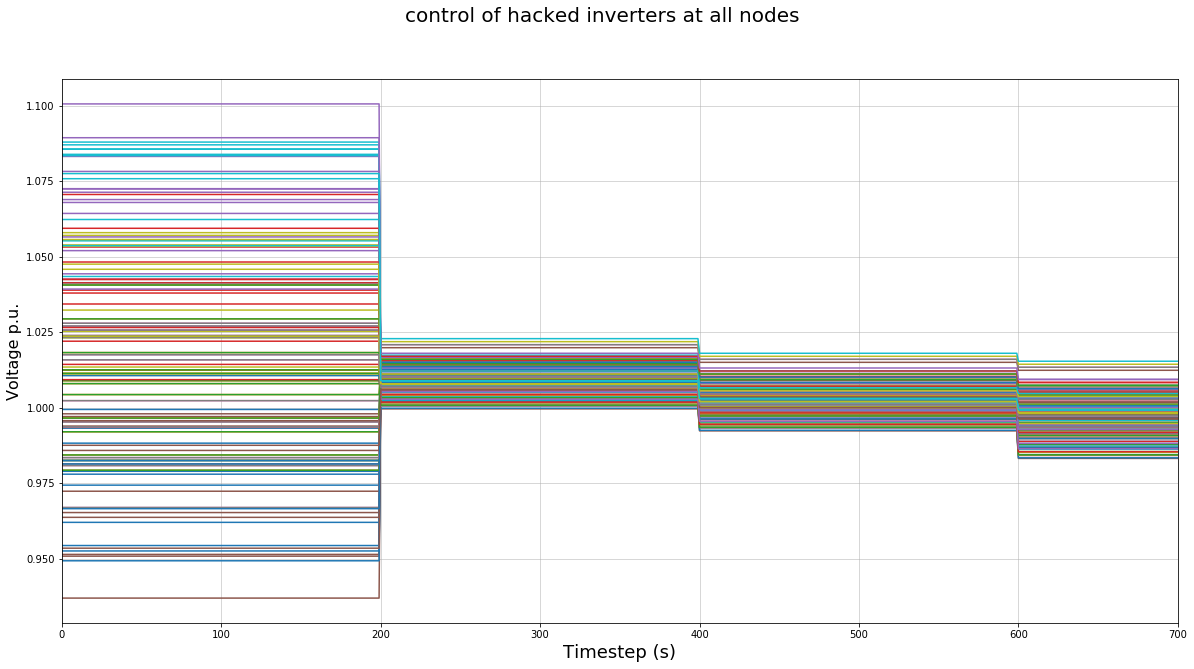

In [51]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 700])
f.suptitle('control of hacked inverters at all nodes', fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
for key in Logger.log_dict.keys():
#     if 'adversary_' not in key and 'inverter_' in key:       
#         ax.plot(Logger.log_dict[key]['control_setting'])
    if 'adversary_' in key and 'inverter_' in key:       
        ax.plot(Logger.log_dict[key]['control_setting'])
plt.show()

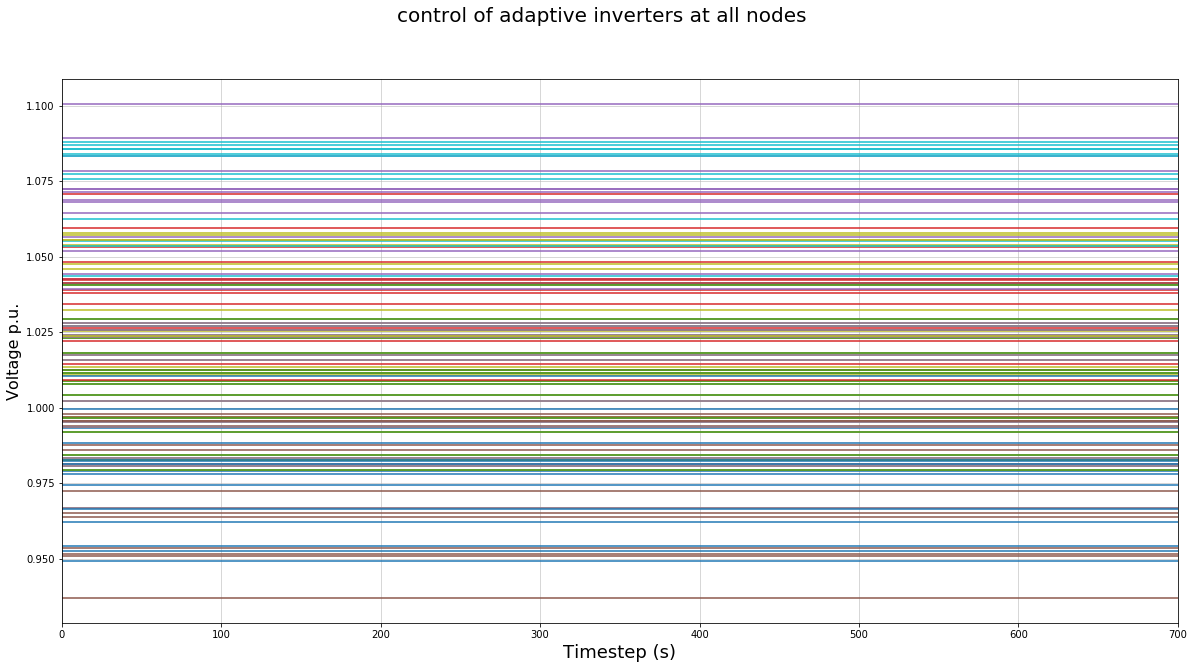

In [56]:
import matplotlib.pyplot as plt 
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 700])
f.suptitle('control of adaptive inverters at all nodes', fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Voltage p.u.', fontsize=16)
for key in Logger.log_dict.keys():
#     if 'adversary_' not in key and 'inverter_' in key:       
#         ax.plot(Logger.log_dict[key]['control_setting'])
    if 'adversary_' not in key and 'inverter_' in key:       
        ax.plot(Logger.log_dict[key]['control_setting'])
plt.show()

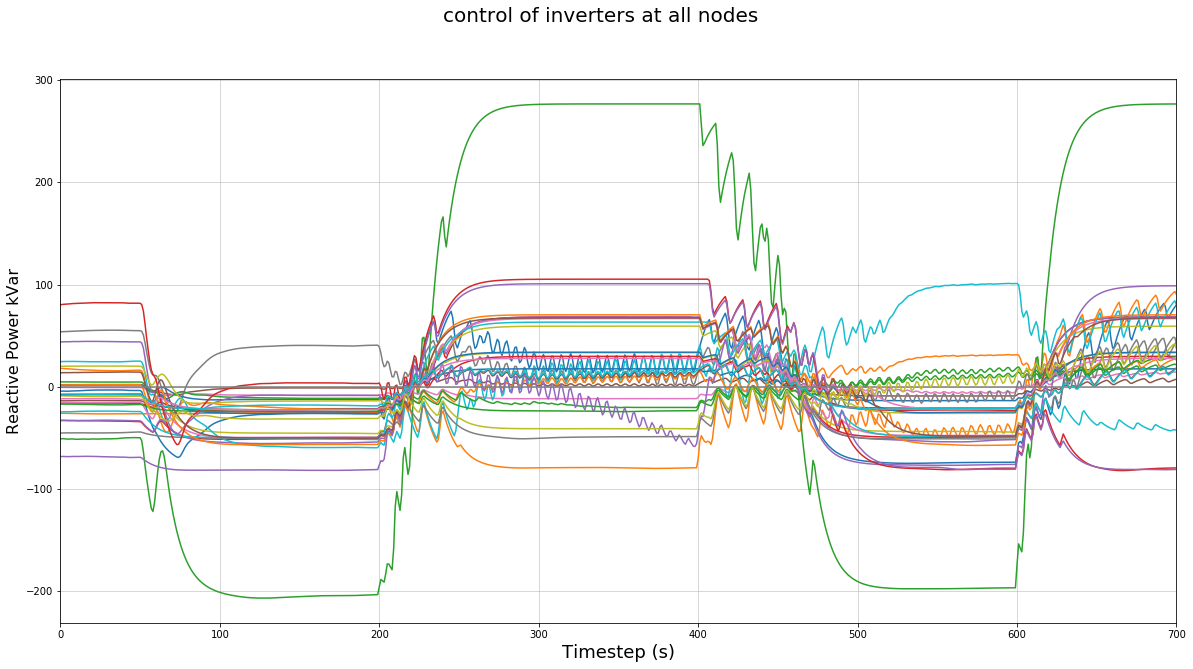

In [36]:
f, ax = plt.subplots(figsize=(20, 10))

ax.grid(linestyle='-', linewidth=0.5)
ax.set_xlim([0, 700])
f.suptitle('control of inverters at all nodes', fontsize=20)
plt.xlabel('Timestep (s)', fontsize=18)
plt.ylabel('Reactive Power kVar', fontsize=16)
for key in Logger.log_dict.keys():
#     if 'adversary_' not in key and 'inverter_' in key:       
#         ax.plot(Logger.log_dict[key]['control_setting'])
    if 'adversary_' in key and 'inverter_' in key:       
        ax.plot(Logger.log_dict[key]['q_out'])
plt.show()